In [1]:
import os
import cv2
import editdistance
from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook as tqdm
import editdistance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.listdir()

/home/rob/anaconda3/envs/hwrtf/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


["Compare predictions to 'GT' - copenhagen.ipynb",
 '.ipynb_checkpoints',
 '.~lock.Aarhus M alcon specimen label data.xls#',
 'zooniverse_words_for_training.csv',
 'zooniverse_predictions.txt',
 '.~lock.copenhagen_gt.xlsx#',
 'aarhus_predictions.txt',
 "Compare predictions to 'GT' - zooniverse.ipynb",
 'Aarhus M alcon specimen label data.xls',
 'zooniverse_word_scores.csv',
 "Compare predictions to 'GT' - aarhus.ipynb",
 '.~lock.danish-butterflies-and-moths-2020-challenge-classifications.csv#',
 'danish-butterflies-and-moths-2020-challenge-classifications.csv',
 'Show example zooniverse images.ipynb',
 'copenhagen_gt.xlsx',
 'zooniverse_transcriptions_per_user.csv',
 'zooniverse_transcriptions.csv',
 'copenhagen_predictions.txt',
 'aarhus_word_scores.csv',
 'Download Zooniverse Images.ipynb',
 'test_words_for_SimpleHTR',
 'Show example zooniverse images-Copy1.ipynb']

In [8]:
a = pd.read_csv('zooniverse_transcriptions_per_user.csv',index_col=0)
a[a['subject_ids'] == 222050].iloc[:,5:]

,coll,type,loc,day,month,year,collector,name?,name,sex,genital?,ZMUC,determinator,preparator,genital_num,index,person
3423,F.Schepler,False,Virklund,12,7,1952,NaN,False,NaN,Not specified (unknown),False,NaN,NaN,NaN,NaN,3423,1
10516,"coll. Schepler, F.",False,Virklund,12,7,1952,NaN,False,NaN,Not specified (unknown),False,NaN,NaN,NaN,NaN,10516,2
11534,Coll. F. Schepler,False,Virklund,12,7,1962,[unclear][/unclear],False,NaN,Not specified (unknown),False,NaN,NaN,NaN,NaN,11534,3


In [33]:
gt = pd.read_csv('zooniverse_transcriptions.csv',index_col=[0,1]).swaplevel(0,1)
gt = gt[gt['#agree_fuzz']>=2][['best_fuzz','#agree_fuzz']].reset_index().rename(columns={'level_1':'label'})
gt.head()

,subject_ids,label,best_fuzz,#agree_fuzz
0,219401,coll,Mus. Hauschild,6.0
1,219402,coll,Coll. V. Thomsen,2.0
2,219407,coll,Coll. V. Thomsen,2.0
3,219408,coll,Coll. Klöcker,2.0
4,219409,coll,Coll. Klöcker,2.0


In [34]:

def expand_list(_gts):
    gts_copy = list(_gts.copy())
    for gt in _gts:
        if len(gt.split(' ')) > 1:
            gts = gt.split(' ')
            for i in range(len(gts)):
                for j in range(i,len(gts)):
                    b = ' '.join(gts[i:j+1])
                    if len(b):
                        gts_copy += [b]
    return np.unique(gts_copy)

In [35]:

def get_day_month_year_from_group(group):
    day = group[group['label']=='day']['best_fuzz'].values
    if len(day):
        try:
            day = str(int(day[0]))
        except:
            year = np.nan
    else:
        day = np.nan
    month = group[group['label']=='month']['best_fuzz'].values
    if len(month):
        try:
            month = str(int(month[0]))
        except:
            year = np.nan
    else:
        month = np.nan    
    year = group[group['label']=='year']['best_fuzz'].values
    if len(year):
        try:
            year = str(int(year[0]))
        except:
            year = np.nan
    else:
        year = np.nan
    return day,month,year

def make_date_combinations(day,month,year):
    seperators = ['.','/','-']
    combs = []
    if not np.isnan(float(year)):
        year_short = year[2:]
    for seperator in seperators:
        if np.isnan(float(day)) & np.isnan(float(month)) & np.isnan(float(year)):
            continue
        elif np.isnan(float(day)) & np.isnan(float(month)):
            continue
        elif np.isnan(float(month)) & np.isnan(float(year)):
            continue
        elif np.isnan(float(day)) & np.isnan(float(year)):
            continue
        elif np.isnan(float(day)):
            combs += [seperator.join([month,year])]
            combs += [seperator.join([month,year_short])]
        elif np.isnan(float(month)):
            continue
        elif np.isnan(float(year)):
            combs += [seperator.join([day,month])]
        else:
            combs += [seperator.join([day,month,year])]
            combs += [seperator.join([day,month,year_short])]
            combs += [seperator.join([day,month])]
            combs += [seperator.join([month,year])]
            combs += [seperator.join([month,year_short])]
    return combs
make_date_combinations('10','10','1910')

['10.10.1910',
 '10.10.10',
 '10.10',
 '10.1910',
 '10.10',
 '10/10/1910',
 '10/10/10',
 '10/10',
 '10/1910',
 '10/10',
 '10-10-1910',
 '10-10-10',
 '10-10',
 '10-1910',
 '10-10']

In [36]:
fps = []
preds = []
with open('zooniverse_predictions.txt','r') as f:
    for line in f.readlines():
        exec('line = [' + line.replace('] [','],[').replace('] None [','], None, [') + ']')
        for i in range(len(line)):
            if i == 0:
                fps += line[i]
            elif i == 1:
                preds += line[i]
        if len(fps) != len(preds):
            print('wtf')
len(fps),len(preds)
preds = pd.DataFrame(np.array([fps,preds]).T,columns=['fp','pred'])
preds['cat_no'] = preds['fp'].map(lambda x: x.split('/')[7].split('_')[0])
preds = preds[['cat_no','pred','fp']]
preds['gt'] = np.nan
preds['score'] = np.nan
preds = preds.sample(frac=1)

In [38]:
preds.head()

,cat_no,pred,fp,gt,score
1934,220614,1-8-1964.,/home/rob/HWR/datasets/zooniverse/words/220614...,NaN,NaN
5010,220762,,/home/rob/HWR/datasets/zooniverse/words/220762...,NaN,NaN
6138,222097,"Bolial""0e",/home/rob/HWR/datasets/zooniverse/words/222097...,NaN,NaN
7480,222906,to,/home/rob/HWR/datasets/zooniverse/words/222906...,NaN,NaN
2907,220729,i,/home/rob/HWR/datasets/zooniverse/words/220729...,NaN,NaN


In [79]:
gt['pred'] = np.nan
gt['pred_score'] = np.nan
gt['dist'] = np.nan
gt['n'] = np.nan
i=0
for name,row in tqdm(gt.iterrows(),total=len(gt)):
    gtText = row['best_fuzz']
    cat_no = row['subject_ids']
    possible_preds = preds[preds['cat_no'] == str(cat_no)]['pred'].values
    
    best_score = 0
    best_gt = ''
    if len(possible_preds):
        for possible_pred in possible_preds:
            score = fuzz.token_sort_ratio(gtText,possible_pred)
            #print(pred, possible_gt, score)
            if score > best_score:
                gt.loc[name,'pred'] = possible_pred
                gt.loc[name,'pred_score'] = score
                gt.loc[name,'dist'] = editdistance.eval(possible_pred,gtText)
                gt.loc[name,'n'] = len(gtText)
                best_score = score
    else:
        gt.loc[name,'dist'] = editdistance.eval('',gtText)
    
    gt.loc[name,'n'] = len(gtText)
    print(gtText,possible_preds,best_score,gt.loc[name,'pred'])
    i+=1
    if i ==100:
        break



Mus. Hauschild ['lsia' '.' 't' 'pragas'] 21 pragas
Coll. V. Thomsen ['Mitieon'] 19 Mitieon
Coll. V. Thomsen [] 0 nan
Coll. Klöcker [] 0 nan
Coll. Klöcker ['andhl' 'Wrledais'] 21 Wrledais
Coll. Klöcker [] 0 nan
Coll. S. Doblmann ['giral' 'ai' 'Bazgere' 'fall' 'bobteasts'] 33 bobteasts
coll. S. Dohlmann [] 0 nan
Coll. S. Dohlmann [] 0 nan
'coll.' R.H. Stamm [] 0 nan
Coll. R. H. Stamm [] 0 nan
Coll. R. H. Stamm [] 0 nan
L. P. Jensen [] 0 nan
Coll. L. P. Jensen [] 0 nan
Coll. L. P. Jensen ['a' 'll' 'Lil-ferson'] 32 Lil-ferson
Coll. L. P. jensen [] 0 nan
Hageded, J. ['Bislageded' '22d'] 63 Bislageded
Feddersen, T. ['Fellenson'] 40 Fellenson
Nielsen, P.K. ['3' 'Pklt' '3.G/914' 'Wielsen' 'savehesk'] 67 Wielsen
Ejvind Kjær ['cl' 'Goll' 'Zngner'] 25 Zngner
Coll. T Feddersen [] 0 nan
Coll. T. Feddersen ['Felersen' 'Gall' '.'] 58 Felersen
Feddersen, T. ['coll' 'Enddarean'] 50 Enddarean
coll. Feddersen, T. [] 0 nan
Coll. B W. Rasmussen ['Lariendad' 'zovl-n3' 'SiR' 'P-cuocseand' '6alle'] 41 P-cuocs

In [60]:
CER = gt['dist'].sum()/gt['n'].sum()
CER

0.8452723812625301

In [64]:
gt

,subject_ids,label,best_fuzz,#agree_fuzz,pred,pred_score,CER,dist,n
0,219401,coll,Mus. Hauschild,6.0,pragas,21.0,12.0,12.0,14.0
1,219402,coll,Coll. V. Thomsen,2.0,Mitieon,19.0,14.0,14.0,16.0
2,219407,coll,Coll. V. Thomsen,2.0,NaN,NaN,16.0,16.0,16.0
3,219408,coll,Coll. Klöcker,2.0,NaN,NaN,13.0,13.0,13.0
4,219409,coll,Coll. Klöcker,2.0,Wrledais,21.0,12.0,12.0,13.0
5,219410,coll,Coll. Klöcker,2.0,NaN,NaN,13.0,13.0,13.0
6,219411,coll,Coll. S. Doblmann,2.0,bobteasts,33.0,15.0,15.0,17.0
7,219412,coll,coll. S. Dohlmann,6.0,NaN,NaN,17.0,17.0,17.0
8,219413,coll,Coll. S. Dohlmann,2.0,NaN,NaN,17.0,17.0,17.0
9,219423,coll,'coll.' R.H. Stamm,6.0,NaN,NaN,18.0,18.0,18.0


In [63]:
len(gt[gt['pred'] == gt['best_fuzz']])/len(gt)

0.007071765322158198

In [30]:
for name,row in tqdm(preds.iterrows(),total = len(preds)):
    pred = row['pred']
    cat_no = row['cat_no']
    fp = row['fp']
    #img = cv2.imread(fp)
    #plt.imshow(img)
    subject_gts = gt[gt['subject_ids']==int(cat_no)]
    day,month,year = get_day_month_year_from_group(subject_gts)
    possible_gts = subject_gts['best_fuzz'].values
    possible_gts = list(expand_list(possible_gts))
    possible_gts += make_date_combinations(day,month,year)
    possible_gts += ['Coll','Coll.','Dania','zmuc','Dania, coll.']
    
    best_score = 0
    best_gt = ''
    if len(possible_gts):
        for possible_gt in possible_gts:
            score = fuzz.token_sort_ratio(pred,possible_gt)
            #print(pred, possible_gt, score)
            if score > best_score:
                preds.loc[name,'gt'] = possible_gt
                preds.loc[name,'score'] = score
                best_score = score

KeyboardInterrupt: 

In [322]:
fuzz.token_sort_ratio('Danis','Dania')

80

In [340]:
len(preds),len(preds.dropna()),len(preds[preds['score']>=70])

(10400, 9559, 1904)

In [381]:

preds.to_csv('zooniverse_word_scores.csv')

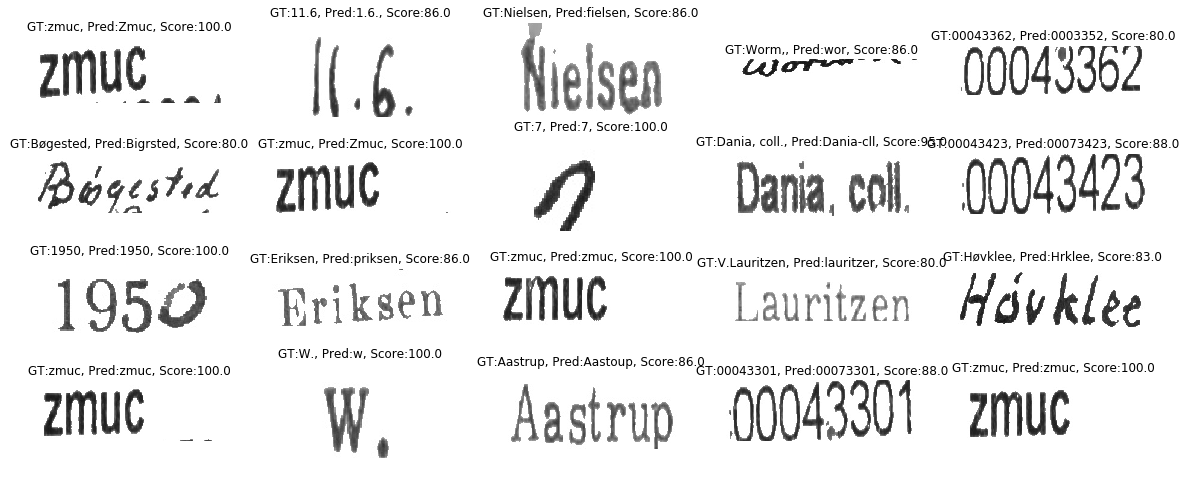

In [379]:
preds = preds.sample(frac=1)

n_cols = 5
n_rows = 4

n_images = n_cols*n_rows
min_score=80
fps = preds[preds['score']>=min_score]['fp'].values
gts = preds[preds['score']>=min_score]['gt'].values
ps = preds[preds['score']>=min_score]['pred'].values
scores = preds[preds['score']>=min_score]['score'].values

fig = plt.figure(figsize=(n_cols*4, n_rows*2))

for i in range(1,n_images+1):
    try:
        img = cv2.imread(fps[i])
        fig.add_subplot(n_rows, n_cols, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('GT:' + gts[i] + ', Pred:' + ps[i] + ', Score:'+str(scores[i]))
        plt.axis('off')
    except Exception as ex:
        print('Exception: %s'%ex)
        pass
plt.show()


In [368]:
preds.dropna()[preds.dropna()['gt'].map(lambda x: 'ø' in x)]

,cat_no,pred,fp,gt,score
3488,221709,Wostende,/home/rob/HWR/datasets/zooniverse/words/221709...,Klostermølle,53.0
7921,219637,is,/home/rob/HWR/datasets/zooniverse/words/219637...,Broksø,29.0
9898,219773,somder00r9,/home/rob/HWR/datasets/zooniverse/words/219773...,Sønderborg,53.0
8729,221892,-ostennokle,/home/rob/HWR/datasets/zooniverse/words/221892...,Klostermølle,57.0
1630,222432,Grontalt,/home/rob/HWR/datasets/zooniverse/words/222432...,grønholt,67.0
6428,219404,Lite,/home/rob/HWR/datasets/zooniverse/words/219404...,Søllerød,40.0
699,220386,Horblege,/home/rob/HWR/datasets/zooniverse/words/220386...,Høvblege,80.0
9761,220981,Fns,/home/rob/HWR/datasets/zooniverse/words/220981...,Søby,33.0
1430,219773,Pil-ergensen,/home/rob/HWR/datasets/zooniverse/words/219773...,L. Jørgensen,82.0
1940,222816,les,/home/rob/HWR/datasets/zooniverse/words/222816...,Ganløse,44.0


In [145]:
fps = []
preds = []
with open('zooniverse_predictions.txt','r') as f:
    for line in f.readlines():
        for i in range(len(line.split('['))):
            _list = line.split('[')[i]
            _list = _list.split('] ')[0]
            _list = _list.replace("'",'')
            _list = _list.split(',')
            _list = [x.strip() for x in _list]
            if i == 1:
                fps += _list
                print(len(_list))
            elif i == 2:
                preds += _list
                print(_list)
        if len(preds) != len(fps):
            print('wtf')
            print(line.split('[')[2])
            break
                    

200
['Tntlleck', 'Fxoster', 'call', 'iby', 'bo', 'zmmuc', '977-69', 'Vibdra', '1/7-3', 'call', '1-70g6', '193', '6alh', 'Mitieon', 'ZilUAser', 'Gammekhas', 'anand', 'Weis', '0l3', 'Fensen', 'IVAM2', 'Ptl-Wy', '1957-1260', 'Bas', 'INtdnke', 'zmuc', 'lanritzek', 'e', 'ymerad', 'Dansiz-cok', '7', '0alh', '20-2-63', 'o', 'Danior', 'ZnteSero', 'srewed', 'fo', 'in', 'Coll', 'oe', 'WiLanfemanh', 'zmuc', 'Teniteoions', '1ag-6', 'pinarIm', 'elelous', 'gersenaley', 'unn', 'I', 'Lwd', 'Henritsen', '34', 'ZlA48', 'Eadngeos', 'pasterase', 'rorin', 'gidr', '00n73391', 'addrecen', 's', 'FamemnPeterses', 'Pédensen', 'Gronnal', 'cank', 'Dte', '1-7-19686.', 'iloplek', 'catl', '', '"9"', 'a9', 'Tteleoz', 'HOpLERe', 'col-aresersen', 'aribstou', 'Clh', 'Borbzese', 'Rastadnose', 'd', '-in', 'arave', 'Saarisest', 'Wiehlwnd', 'Calk', 'PoE55Ynk', 'inorgiserd', 'a', 'zmec', 'a', 'pana', 'P.', '0', 'Fensen', 'M', 'wole', 'dikeislig', 'Zundovist', '7.4.', 'Icsien', 'U-Ulsert', 'Vchnistollersen', 'dieialea', 'Echo

In [119]:
_list

['33.11498']

In [107]:
df = pd.read_csv('zooniverse_transcriptions_per_user.csv',index_col=1)
df = df.drop(['Unnamed: 0','person','type','name?','sex','accession','labels_vis','created_at','user_id','genital?','index'],axis=1)
df = df.replace('Not specified (unknown)',np.nan).replace('[unclear][/unclear]',np.nan).replace('[uklar][/uklar]',np.nan).replace(False, np.nan).replace('',np.nan).replace(' ',np.nan).dropna(how='all',axis=0)
df = df.stack().reset_index()
for name,group in df.groupby('subject_ids'):
    print(group)
    break

       subject_ids level_1               0
6642        219401    coll  Mus. Hauschild
6643        219401     loc      Jægerspris
6644        219401     day              12
6645        219401   month               9
6646        219401    year            1914
11352       219401    coll  Mus. Hauschild
11353       219401     loc      Jægerspris
11354       219401     day              12
11355       219401   month               9
14568       219401    coll  Mus. Hauschild
14569       219401     loc      Jægerspris
14570       219401     day              12
14571       219401   month               9
14572       219401    year            1914


In [17]:

df = pd.read_csv('aarhus_word_scores.csv', index_col = 0)
for name,row in df[df['score']>=70].iterrows():
    gt =row['gt']
    fp= row['fp']

    print(gt,fp)
    break
df

1926 /home/rob/HWR/datasets/Aarhus/words/199383_2_OCR_1.jpg


,cat_no,pred,fp,gt,score
1622,199062,Vaiknd,/home/rob/HWR/datasets/Aarhus/words/199062_0_O...,Dania,36.0
1192,199024,1950r,/home/rob/HWR/datasets/Aarhus/words/199024_1_O...,1947,44.0
1418,199383,.,/home/rob/HWR/datasets/Aarhus/words/199383_0_H...,NaN,NaN
1093,199397,Bstivland,/home/rob/HWR/datasets/Aarhus/words/199397_1_O...,Langer,40.0
97,199311,reerr,/home/rob/HWR/datasets/Aarhus/words/199311_0_O...,Kandestederne,33.0
912,199298,lihitene,/home/rob/HWR/datasets/Aarhus/words/199298_0_O...,H.,22.0
1713,199148,Fl,/home/rob/HWR/datasets/Aarhus/words/199148_0_H...,Coll,33.0
47,199276,Nr.,/home/rob/HWR/datasets/Aarhus/words/199276_1_O...,Jens,33.0
127,199383,Namierske,/home/rob/HWR/datasets/Aarhus/words/199383_2_O...,Hammer,53.0
955,199059,-,/home/rob/HWR/datasets/Aarhus/words/199059_0_H...,NaN,NaN


In [18]:
df[df['score']<70]['fp'].to_csv('aarhus_test_words.csv',index=False)

In [24]:
from glob import glob
fps = glob('/home/rob/HWR/datasets/Copenhagen/Words/*.jpg')
pd.Series(fps).to_csv('copenhagen_test_words.csv',index=False)